# Análisis Inicial de Vivienda y Demografía de Barcelona - EDA
    
Este cuaderno realiza un Análisis Exploratorio de Datos (EDA) inicial sobre la base de datos consolidada.

**Objetivos:**
1. Comprobaciones de Calidad de Datos (Nulos, cobertura, lagunas temporales)
2. Análisis de Distribución de Precios (venta y alquiler)
3. Análisis Demográfico (básico y ampliado)
4. Análisis de Renta (Ingresos)
5. Análisis de Correlación (precios, demografía, renta)
6. Visualización Geográfica
7. Detección de Valores Atípicos
8. Análisis de Tendencias Temporales

**Última actualización**: 17 de noviembre de 2025


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import plotly.express as px
import plotly.graph_objects as go
import json

# Configure plotting
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
%matplotlib inline

# Connect to database
DB_PATH = '../data/processed/database.db'
conn = sqlite3.connect(DB_PATH)

print("Libraries loaded and database connected.")

Libraries loaded and database connected.


## 1. Visión General de Datos y Comprobaciones de Calidad

In [22]:
# Load main tables
df_barrios = pd.read_sql("SELECT * FROM dim_barrios", conn)
df_precios = pd.read_sql("SELECT * FROM fact_precios", conn)
df_demo = pd.read_sql("SELECT * FROM fact_demografia", conn)
df_demo_amp = pd.read_sql("SELECT * FROM fact_demografia_ampliada", conn)
df_renta = pd.read_sql("SELECT * FROM fact_renta", conn)
df_idealista = pd.read_sql("SELECT * FROM fact_oferta_idealista", conn)

print("=== RESUMEN DE DATOS ===")
print(f"Barrios: {df_barrios.shape}")
print(f"Precios: {df_precios.shape}")
print(f"Demografia (básica): {df_demo.shape}")
print(f"Demografia (ampliada): {df_demo_amp.shape}")
print(f"Renta: {df_renta.shape}")
print(f"Oferta Idealista: {df_idealista.shape}")

# Cobertura temporal
print("\n=== COBERTURA TEMPORAL ===")
print(f"Demografia: {df_demo['anio'].min()} - {df_demo['anio'].max()}")
print(f"Precios: {df_precios['anio'].min()} - {df_precios['anio'].max()}")
if not df_renta.empty:
    print(f"Renta: {df_renta['anio'].min()} - {df_renta['anio'].max()}")
else:
    print("Renta: Sin datos")

=== RESUMEN DE DATOS ===
Barrios: (73, 13)
Precios: (9927, 10)
Demografia (básica): (657, 13)
Demografia (ampliada): (2256, 11)
Renta: (73, 13)
Oferta Idealista: (0, 19)

=== COBERTURA TEMPORAL ===
Demografia: 2015 - 2023
Precios: 2012 - 2025
Renta: 2022 - 2022


In [23]:
# Check for NULLs in all tables
print("=== ANÁLISIS DE VALORES FALTANTES ===\n")

print("--- fact_precios ---")
nulls_precios = df_precios.isnull().sum()
print(nulls_precios[nulls_precios > 0])
print(f"Total registros: {len(df_precios)}")
print(f"Registros con precio_m2_venta: {df_precios['precio_m2_venta'].notna().sum()} ({df_precios['precio_m2_venta'].notna().sum()/len(df_precios)*100:.1f}%)")
print(f"Registros con precio_mes_alquiler: {df_precios['precio_mes_alquiler'].notna().sum()} ({df_precios['precio_mes_alquiler'].notna().sum()/len(df_precios)*100:.1f}%)")

print("\n--- fact_demografia ---")
nulls_demo = df_demo.isnull().sum()
print(nulls_demo[nulls_demo > 0])
if nulls_demo.sum() > 0:
    print(f"Total registros: {len(df_demo)}")
    for col in df_demo.columns:
        if df_demo[col].isnull().sum() > 0:
            pct = df_demo[col].isnull().sum() / len(df_demo) * 100
            print(f"  {col}: {df_demo[col].isnull().sum()} NULLs ({pct:.1f}%)")

print("\n--- fact_renta ---")
if not df_renta.empty:
    nulls_renta = df_renta.isnull().sum()
    print(nulls_renta[nulls_renta > 0])
    print(f"Total registros: {len(df_renta)}")
    print(f"Años únicos: {df_renta['anio'].nunique()}")
else:
    print("Sin datos")

print("\n--- fact_demografia_ampliada ---")
nulls_demo_amp = df_demo_amp.isnull().sum()
print(nulls_demo_amp[nulls_demo_amp > 0])
print(f"Total registros: {len(df_demo_amp)}")
print(f"Grupos de edad únicos: {df_demo_amp['grupo_edad'].nunique() if 'grupo_edad' in df_demo_amp.columns else 'N/A'}")
print(f"Nacionalidades únicas: {df_demo_amp['nacionalidad'].nunique() if 'nacionalidad' in df_demo_amp.columns else 'N/A'}")

=== ANÁLISIS DE VALORES FALTANTES ===

--- fact_precios ---
trimestre              9927
precio_m2_venta        1730
precio_mes_alquiler    8197
dtype: int64
Total registros: 9927
Registros con precio_m2_venta: 8197 (82.6%)
Registros con precio_mes_alquiler: 1730 (17.4%)

--- fact_demografia ---
porc_inmigracion    20
dtype: int64
Total registros: 657
  porc_inmigracion: 20 NULLs (3.0%)

--- fact_renta ---
Series([], dtype: int64)
Total registros: 73
Años únicos: 1

--- fact_demografia_ampliada ---
Series([], dtype: int64)
Total registros: 2256
Grupos de edad únicos: 4
Nacionalidades únicas: 6


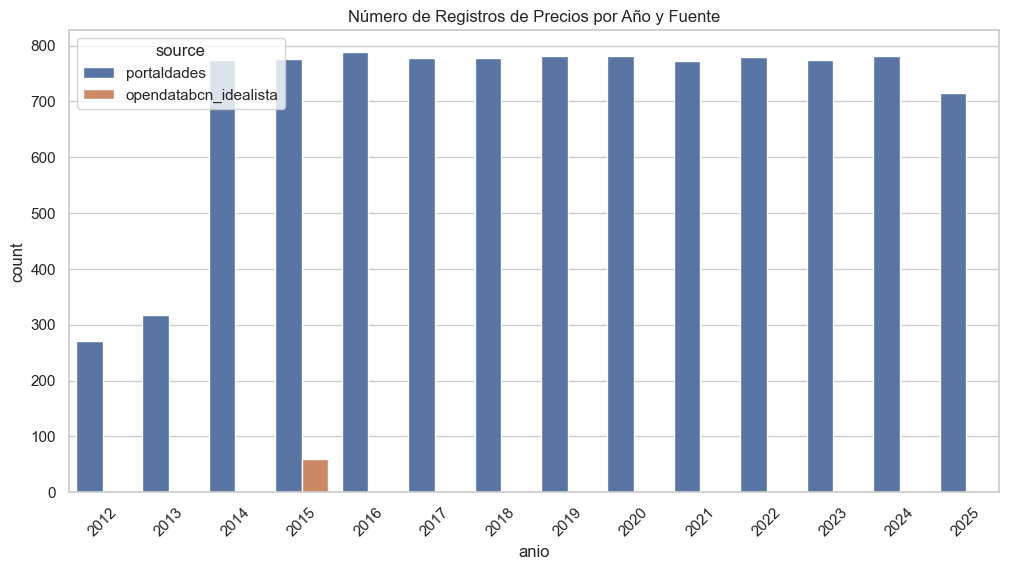

In [ ]:
# Price records by Year and Source
plt.figure(figsize=(12, 6))
sns.countplot(data=df_precios, x='anio', hue='source')
plt.title('Número de Registros de Precios por Año y Fuente')
plt.xticks(rotation=45)
plt.show()

## 2. Análisis de Distribución de Precios

Análisis de distribución de precios de venta y alquiler por m².

In [25]:
# List available datasets in prices
dataset_counts = df_precios['dataset_id'].value_counts().head(10)
print("Top 10 Datasets by Record Count:")
print(dataset_counts)

Top 10 Datasets by Record Count:
dataset_id
mrslyp5pcq    993
bxtvnxvukh    988
hostlmjrdo    988
idjhkx1ruj    969
b37xv8wcjh    866
5ibudgqbrb    864
la6s9fp57r    860
u25rr7oxh6    859
9ap8lewvtt    857
cq4causxvu    857
Name: count, dtype: int64


=== ESTADÍSTICAS DESCRIPTIVAS - PRECIOS ===

--- Precio de Venta (€/m²) ---
count     5687.000000
mean      3086.578497
std       1339.924079
min        502.500000
25%       2125.958571
50%       2933.880000
75%       3936.083382
max      12452.820000
Name: precio_m2_venta, dtype: float64

--- Precio de Alquiler (€/m²/mes) ---
count    860.000000
mean      12.733912
std        2.966712
min        5.360000
25%       10.754800
50%       12.642175
75%       14.576816
max       22.928365
Name: precio_mes_alquiler, dtype: float64


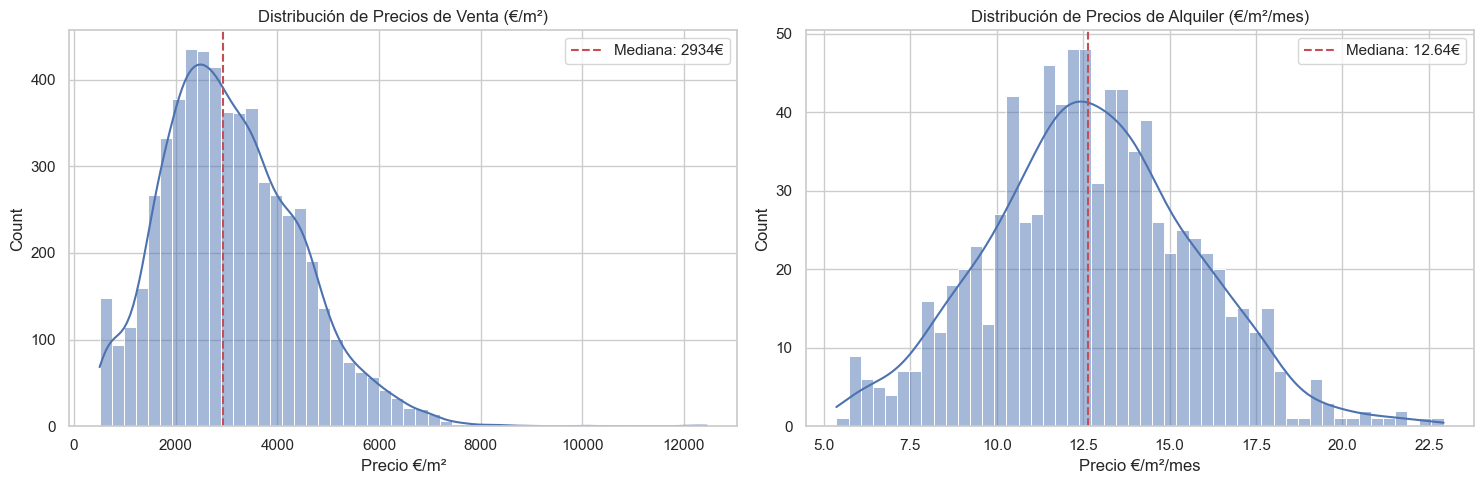

In [26]:
# Filter for reasonable price/m2 values to exclude outliers and total prices
df_m2_venta = df_precios[
    (df_precios['precio_m2_venta'] > 500) & 
    (df_precios['precio_m2_venta'] < 15000)
].copy()

df_m2_alquiler = df_precios[
    (df_precios['precio_mes_alquiler'] > 5) & 
    (df_precios['precio_mes_alquiler'] < 50)
].copy()

# Estadísticas descriptivas
print("=== ESTADÍSTICAS DESCRIPTIVAS - PRECIOS ===")
print("\n--- Precio de Venta (€/m²) ---")
print(df_m2_venta['precio_m2_venta'].describe())

print("\n--- Precio de Alquiler (€/m²/mes) ---")
if not df_m2_alquiler.empty:
    print(df_m2_alquiler['precio_mes_alquiler'].describe())
else:
    print("Sin datos suficientes")

# Distribución de precios de venta
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df_m2_venta['precio_m2_venta'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribución de Precios de Venta (€/m²)')
axes[0].set_xlabel('Precio €/m²')
axes[0].axvline(df_m2_venta['precio_m2_venta'].median(), color='r', linestyle='--', label=f'Mediana: {df_m2_venta["precio_m2_venta"].median():.0f}€')
axes[0].legend()

if not df_m2_alquiler.empty:
    sns.histplot(df_m2_alquiler['precio_mes_alquiler'], bins=50, kde=True, ax=axes[1])
    axes[1].set_title('Distribución de Precios de Alquiler (€/m²/mes)')
    axes[1].set_xlabel('Precio €/m²/mes')
    axes[1].axvline(df_m2_alquiler['precio_mes_alquiler'].median(), color='r', linestyle='--', label=f'Mediana: {df_m2_alquiler["precio_mes_alquiler"].median():.2f}€')
    axes[1].legend()
else:
    axes[1].text(0.5, 0.5, 'Datos de alquiler\ninsuficientes', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Distribución de Precios de Alquiler (€/m²/mes)')

plt.tight_layout()
plt.show()

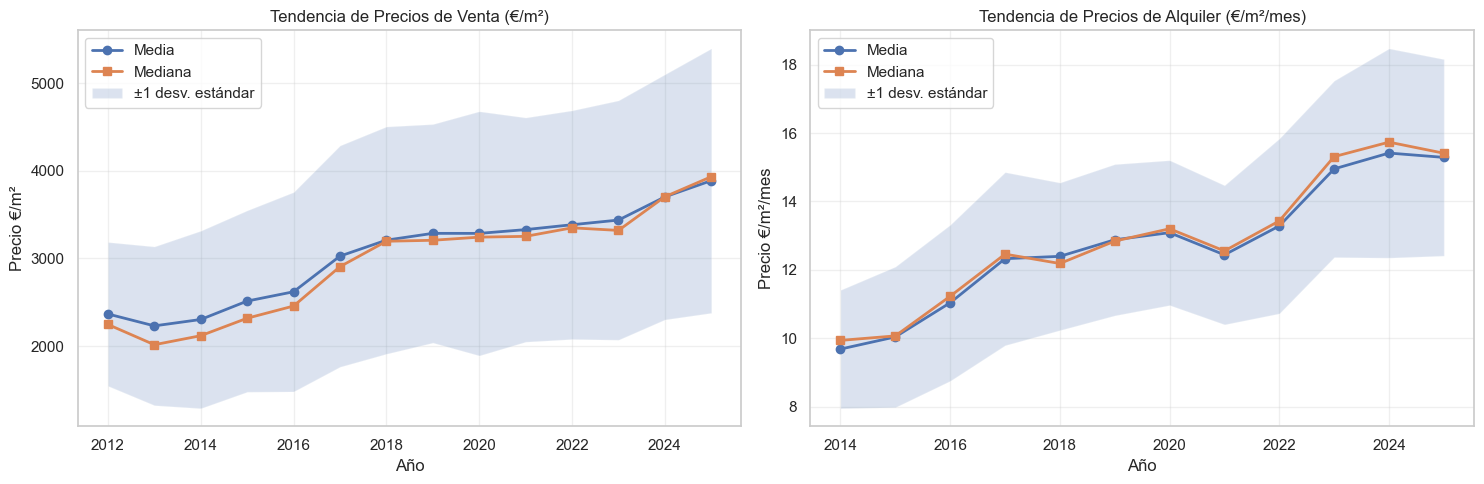

In [27]:
# Price Trends over Time (Average and Median across all barrios)
price_trend_venta = df_m2_venta.groupby('anio')['precio_m2_venta'].agg(['mean', 'median', 'std']).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Venta
axes[0].plot(price_trend_venta['anio'], price_trend_venta['mean'], marker='o', label='Media', linewidth=2)
axes[0].plot(price_trend_venta['anio'], price_trend_venta['median'], marker='s', label='Mediana', linewidth=2)
axes[0].fill_between(price_trend_venta['anio'], 
                     price_trend_venta['mean'] - price_trend_venta['std'],
                     price_trend_venta['mean'] + price_trend_venta['std'],
                     alpha=0.2, label='±1 desv. estándar')
axes[0].set_title('Tendencia de Precios de Venta (€/m²)')
axes[0].set_xlabel('Año')
axes[0].set_ylabel('Precio €/m²')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Alquiler (si hay datos)
if not df_m2_alquiler.empty:
    price_trend_alquiler = df_m2_alquiler.groupby('anio')['precio_mes_alquiler'].agg(['mean', 'median', 'std']).reset_index()
    axes[1].plot(price_trend_alquiler['anio'], price_trend_alquiler['mean'], marker='o', label='Media', linewidth=2)
    axes[1].plot(price_trend_alquiler['anio'], price_trend_alquiler['median'], marker='s', label='Mediana', linewidth=2)
    axes[1].fill_between(price_trend_alquiler['anio'],
                         price_trend_alquiler['mean'] - price_trend_alquiler['std'],
                         price_trend_alquiler['mean'] + price_trend_alquiler['std'],
                         alpha=0.2, label='±1 desv. estándar')
    axes[1].set_title('Tendencia de Precios de Alquiler (€/m²/mes)')
    axes[1].set_xlabel('Año')
    axes[1].set_ylabel('Precio €/m²/mes')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'Datos de alquiler\ninsuficientes', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Tendencia de Precios de Alquiler (€/m²/mes)')

plt.tight_layout()
plt.show()

## 3. Análisis Demográfico

### 3.1 Demografía Básica

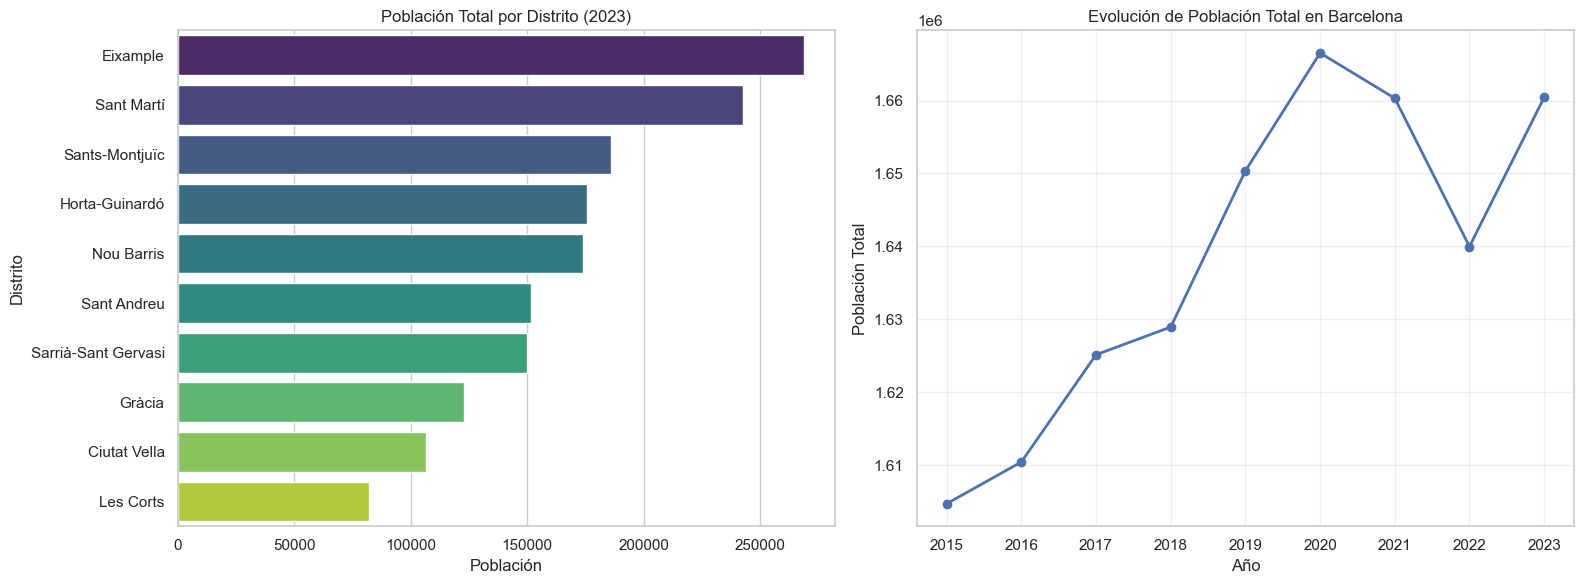

=== ESTADÍSTICAS DEMOGRÁFICAS (Año más reciente) ===
       poblacion_total  poblacion_hombres  poblacion_mujeres  hogares_totales  \
count        73.000000          73.000000          73.000000        73.000000   
mean      22745.684932       11921.493151       10824.191781      9765.027397   
std       14620.714847        7762.403725        6909.017358      6324.394095   
min         699.000000         333.000000         366.000000       300.000000   
25%       10857.000000        5541.000000        5316.000000      4603.000000   
50%       22041.000000       11098.000000       10342.000000      9357.000000   
75%       30437.000000       16295.000000       15184.000000     13103.000000   
max       57902.000000       30635.000000       27346.000000     25161.000000   

       edad_media  densidad_hab_km2  
count   73.000000         73.000000  
mean    66.826904      38465.206996  
std     17.386327      22952.595585  
min     32.518841        270.996977  
25%     55.979689      1953

In [28]:
# Population by District (using latest available year)
latest_year = df_demo['anio'].max()
df_demo_latest = df_demo[df_demo['anio'] == latest_year].merge(
    df_barrios[['barrio_id', 'barrio_nombre', 'distrito_nombre']], 
    on='barrio_id'
)

dist_pop = df_demo_latest.groupby('distrito_nombre')['poblacion_total'].sum().sort_values(ascending=False).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Población por distrito
sns.barplot(data=dist_pop, x='poblacion_total', y='distrito_nombre', hue='distrito_nombre', legend=False, ax=axes[0], palette='viridis')
axes[0].set_title(f'Población Total por Distrito ({latest_year})')
axes[0].set_xlabel('Población')
axes[0].set_ylabel('Distrito')

# Evolución temporal de población total
poblacion_temporal = df_demo.groupby('anio')['poblacion_total'].sum().reset_index()
axes[1].plot(poblacion_temporal['anio'], poblacion_temporal['poblacion_total'], marker='o', linewidth=2)
axes[1].set_title('Evolución de Población Total en Barcelona')
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Población Total')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas demográficas
print("=== ESTADÍSTICAS DEMOGRÁFICAS (Año más reciente) ===")
print(df_demo_latest[['poblacion_total', 'poblacion_hombres', 'poblacion_mujeres', 
                       'hogares_totales', 'edad_media', 'densidad_hab_km2']].describe())

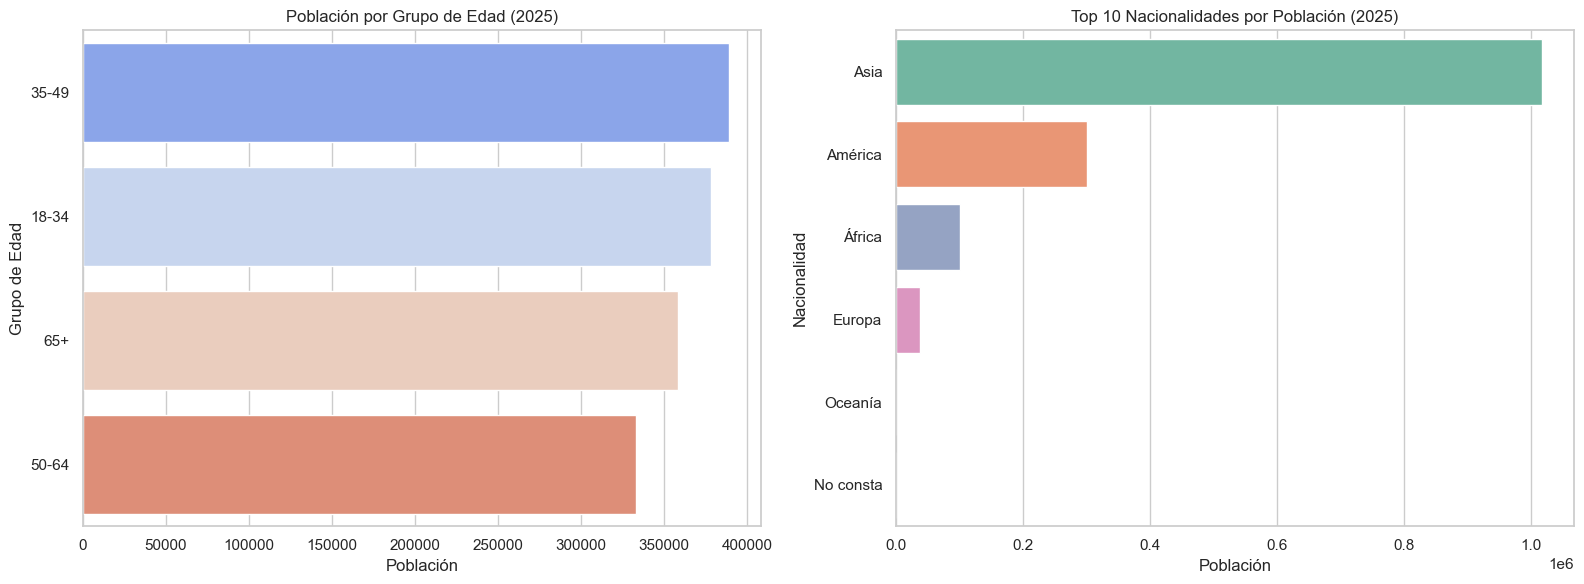

In [29]:
# Análisis de demografía ampliada
if not df_demo_amp.empty and 'grupo_edad' in df_demo_amp.columns:
    # Población por grupo de edad (año más reciente)
    demo_amp_latest = df_demo_amp[df_demo_amp['anio'] == df_demo_amp['anio'].max()]
    
    # Agregar por grupo de edad
    edad_dist = demo_amp_latest.groupby('grupo_edad')['poblacion'].sum().reset_index()
    edad_dist = edad_dist.sort_values('poblacion', ascending=False)
    
    # Agregar por nacionalidad
    if 'nacionalidad' in demo_amp_latest.columns:
        nac_dist = demo_amp_latest.groupby('nacionalidad')['poblacion'].sum().reset_index()
        nac_dist = nac_dist.sort_values('poblacion', ascending=False)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Distribución por edad
    sns.barplot(data=edad_dist, x='poblacion', y='grupo_edad', hue='grupo_edad', legend=False, ax=axes[0], palette='coolwarm')
    axes[0].set_title(f'Población por Grupo de Edad ({demo_amp_latest["anio"].max()})')
    axes[0].set_xlabel('Población')
    axes[0].set_ylabel('Grupo de Edad')
    
    # Distribución por nacionalidad (top 10)
    if 'nacionalidad' in demo_amp_latest.columns:
        sns.barplot(data=nac_dist.head(10), x='poblacion', y='nacionalidad', hue='nacionalidad', legend=False, ax=axes[1], palette='Set2')
        axes[1].set_title(f'Top 10 Nacionalidades por Población ({demo_amp_latest["anio"].max()})')
        axes[1].set_xlabel('Población')
        axes[1].set_ylabel('Nacionalidad')
    
    plt.tight_layout()
    plt.show()
else:
    print("Datos de demografía ampliada no disponibles o estructura incorrecta")


=== ANÁLISIS DE RENTA ===
Columnas disponibles: ['id', 'barrio_id', 'anio', 'renta_euros', 'renta_promedio', 'renta_mediana', 'renta_min', 'renta_max', 'num_secciones', 'barrio_nombre_normalizado', 'dataset_id', 'source', 'etl_loaded_at']

--- Top 10 Barrios por Renta (renta_euros) ---
                        barrio_nombre     distrito_nombre  renta_euros
                      les Tres Torres Sarrià-Sant Gervasi 41344.181818
                            Pedralbes           Les Corts 37844.714286
               Sant Gervasi - Galvany Sarrià-Sant Gervasi 36283.193548
           Sant Gervasi - la Bonanova Sarrià-Sant Gervasi 36110.222222
                               Sarrià Sarrià-Sant Gervasi 35446.375000
        la Vila Olímpica del Poblenou          Sant Martí 32087.600000
               la Dreta de l'Eixample            Eixample 29815.344828
Vallvidrera, el Tibidabo i les Planes Sarrià-Sant Gervasi 29594.666667
                 el Putxet i el Farró Sarrià-Sant Gervasi 29461.421053
   

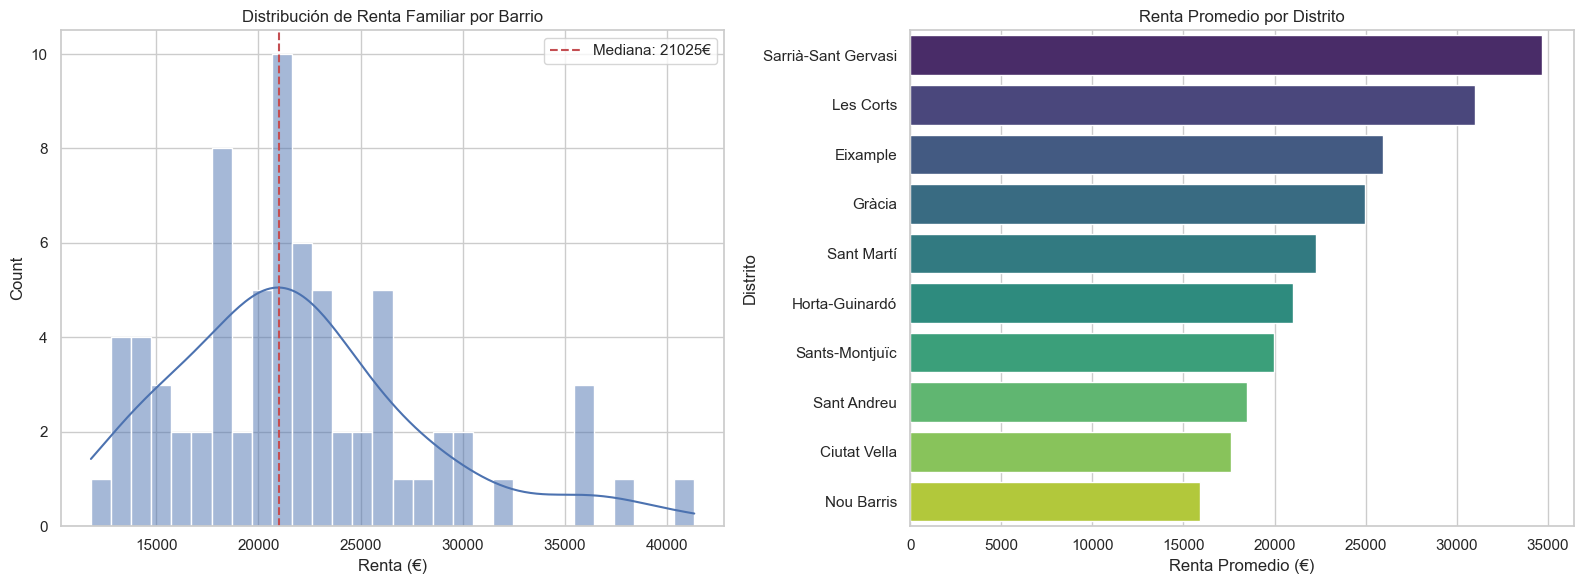

In [30]:
# Análisis de renta
if not df_renta.empty:
    # Verificar qué columnas tiene
    print("=== ANÁLISIS DE RENTA ===")
    print(f"Columnas disponibles: {df_renta.columns.tolist()}")
    
    # Identificar columna de renta (puede ser 'renta_euros', 'renta_promedio', 'importe_euros', etc.)
    renta_col = None
    for col in ['renta_euros', 'renta_promedio', 'importe_euros', 'renta']:
        if col in df_renta.columns:
            renta_col = col
            break
    
    if renta_col:
        df_renta_merged = df_renta.merge(
            df_barrios[['barrio_id', 'barrio_nombre', 'distrito_nombre']],
            on='barrio_id'
        )
        
        # Top y bottom barrios por renta
        top_renta = df_renta_merged.nlargest(10, renta_col)[['barrio_nombre', 'distrito_nombre', renta_col]]
        bottom_renta = df_renta_merged.nsmallest(10, renta_col)[['barrio_nombre', 'distrito_nombre', renta_col]]
        
        print(f"\n--- Top 10 Barrios por Renta ({renta_col}) ---")
        print(top_renta.to_string(index=False))
        
        print(f"\n--- Bottom 10 Barrios por Renta ({renta_col}) ---")
        print(bottom_renta.to_string(index=False))
        
        # Visualización
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Distribución de renta
        sns.histplot(df_renta_merged[renta_col], bins=30, kde=True, ax=axes[0])
        axes[0].axvline(df_renta_merged[renta_col].median(), color='r', linestyle='--', 
                        label=f'Mediana: {df_renta_merged[renta_col].median():.0f}€')
        axes[0].set_title('Distribución de Renta Familiar por Barrio')
        axes[0].set_xlabel('Renta (€)')
        axes[0].legend()
        
        # Renta por distrito
        renta_distrito = df_renta_merged.groupby('distrito_nombre')[renta_col].mean().sort_values(ascending=False).reset_index()
        sns.barplot(data=renta_distrito, x=renta_col, y='distrito_nombre', hue='distrito_nombre', legend=False, ax=axes[1], palette='viridis')
        axes[1].set_title('Renta Promedio por Distrito')
        axes[1].set_xlabel('Renta Promedio (€)')
        axes[1].set_ylabel('Distrito')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No se encontró columna de renta en fact_renta")
        print(f"Columnas: {df_renta.columns.tolist()}")
else:
    print("No hay datos de renta disponibles")


## 3.2 Demografía Ampliada (Edad y Nacionalidad)

Análisis de distribución por grupos de edad y nacionalidad.

Registros para correlación: 655
Registros con renta: 73


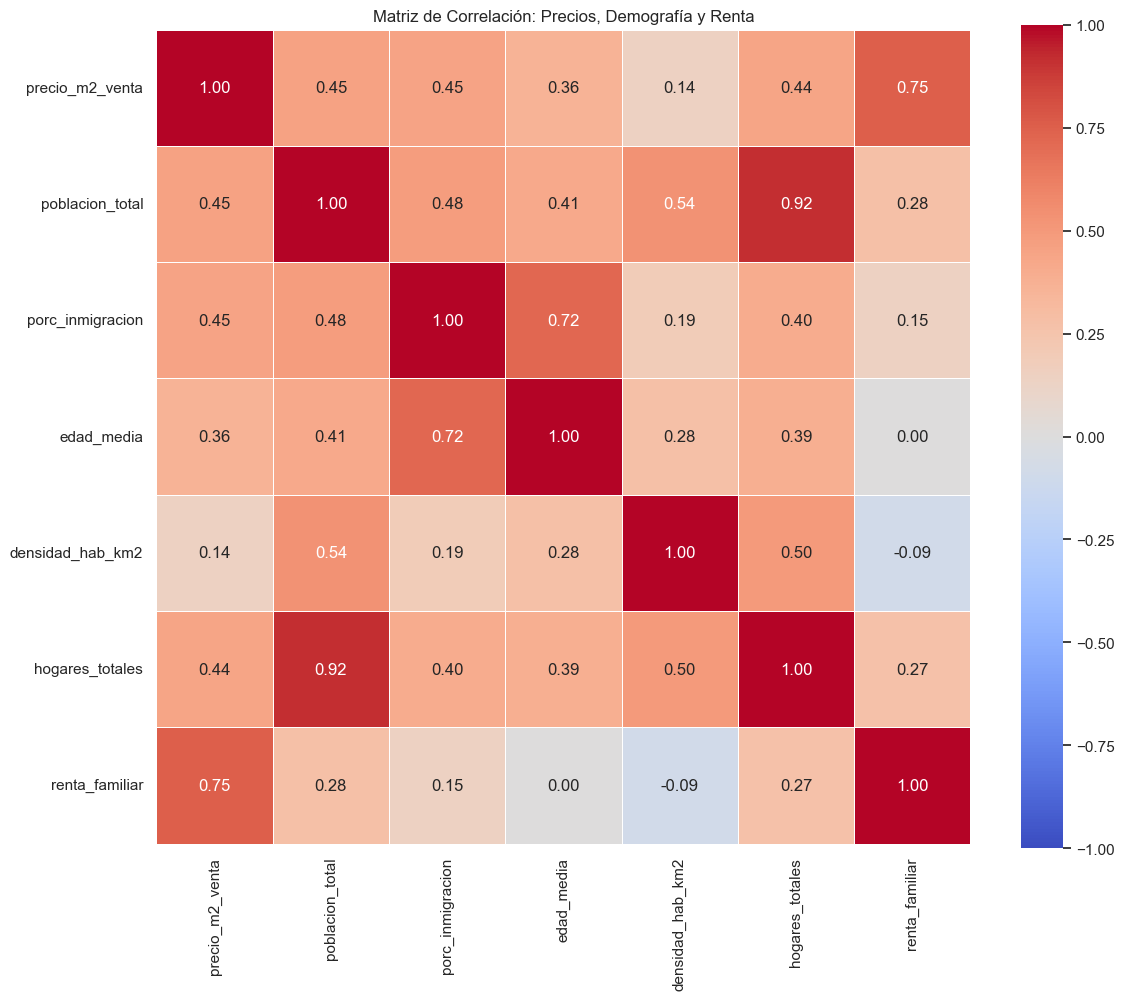


=== CORRELACIONES MÁS FUERTES ===
      Variable 1       Variable 2  Correlación
 poblacion_total  hogares_totales     0.915740
 precio_m2_venta   renta_familiar     0.754693
porc_inmigracion       edad_media     0.722104
 poblacion_total densidad_hab_km2     0.537149
densidad_hab_km2  hogares_totales     0.495432
 poblacion_total porc_inmigracion     0.477670
 precio_m2_venta  poblacion_total     0.454127
 precio_m2_venta porc_inmigracion     0.449103
 precio_m2_venta  hogares_totales     0.442328
 poblacion_total       edad_media     0.414118


In [31]:
# Prepare data for correlation
# 1. Aggregate prices to get one value per barrio-year (mean of m2 prices)
price_agg = df_m2_venta.groupby(['barrio_id', 'anio'])['precio_m2_venta'].mean().reset_index()

# 2. Merge with Renta (identificar columna correcta)
renta_col = None
for col in ['renta_euros', 'renta_promedio', 'importe_euros', 'renta']:
    if col in df_renta.columns:
        renta_col = col
        break

if renta_col:
    renta_clean = df_renta[['barrio_id', 'anio', renta_col]].rename(columns={renta_col: 'renta_familiar'})
else:
    renta_clean = pd.DataFrame(columns=['barrio_id', 'anio', 'renta_familiar'])

# 3. Merge with Demografia
demo_clean = df_demo[['barrio_id', 'anio', 'poblacion_total', 'porc_inmigracion', 
                      'edad_media', 'densidad_hab_km2', 'hogares_totales']]

# Combine
df_corr = price_agg.merge(demo_clean, on=['barrio_id', 'anio'], how='inner')
if not renta_clean.empty:
    df_corr = df_corr.merge(renta_clean, on=['barrio_id', 'anio'], how='left')

print(f"Registros para correlación: {len(df_corr)}")
print(f"Registros con renta: {df_corr['renta_familiar'].notna().sum() if 'renta_familiar' in df_corr.columns else 0}")

# Correlation Matrix (solo variables numéricas)
corr_vars = ['precio_m2_venta', 'poblacion_total', 'porc_inmigracion', 'edad_media', 
             'densidad_hab_km2', 'hogares_totales']
if 'renta_familiar' in df_corr.columns:
    corr_vars.append('renta_familiar')

# Filtrar solo las que existen y tienen suficientes datos
corr_vars = [v for v in corr_vars if v in df_corr.columns and df_corr[v].notna().sum() > 10]

corr_matrix = df_corr[corr_vars].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Matriz de Correlación: Precios, Demografía y Renta')
plt.tight_layout()
plt.show()

# Mostrar correlaciones más fuertes
print("\n=== CORRELACIONES MÁS FUERTES ===")
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append({
            'Variable 1': corr_matrix.columns[i],
            'Variable 2': corr_matrix.columns[j],
            'Correlación': corr_matrix.iloc[i, j]
        })

corr_df = pd.DataFrame(corr_pairs)
corr_df['abs_corr'] = corr_df['Correlación'].abs()
print(corr_df.nlargest(10, 'abs_corr')[['Variable 1', 'Variable 2', 'Correlación']].to_string(index=False))

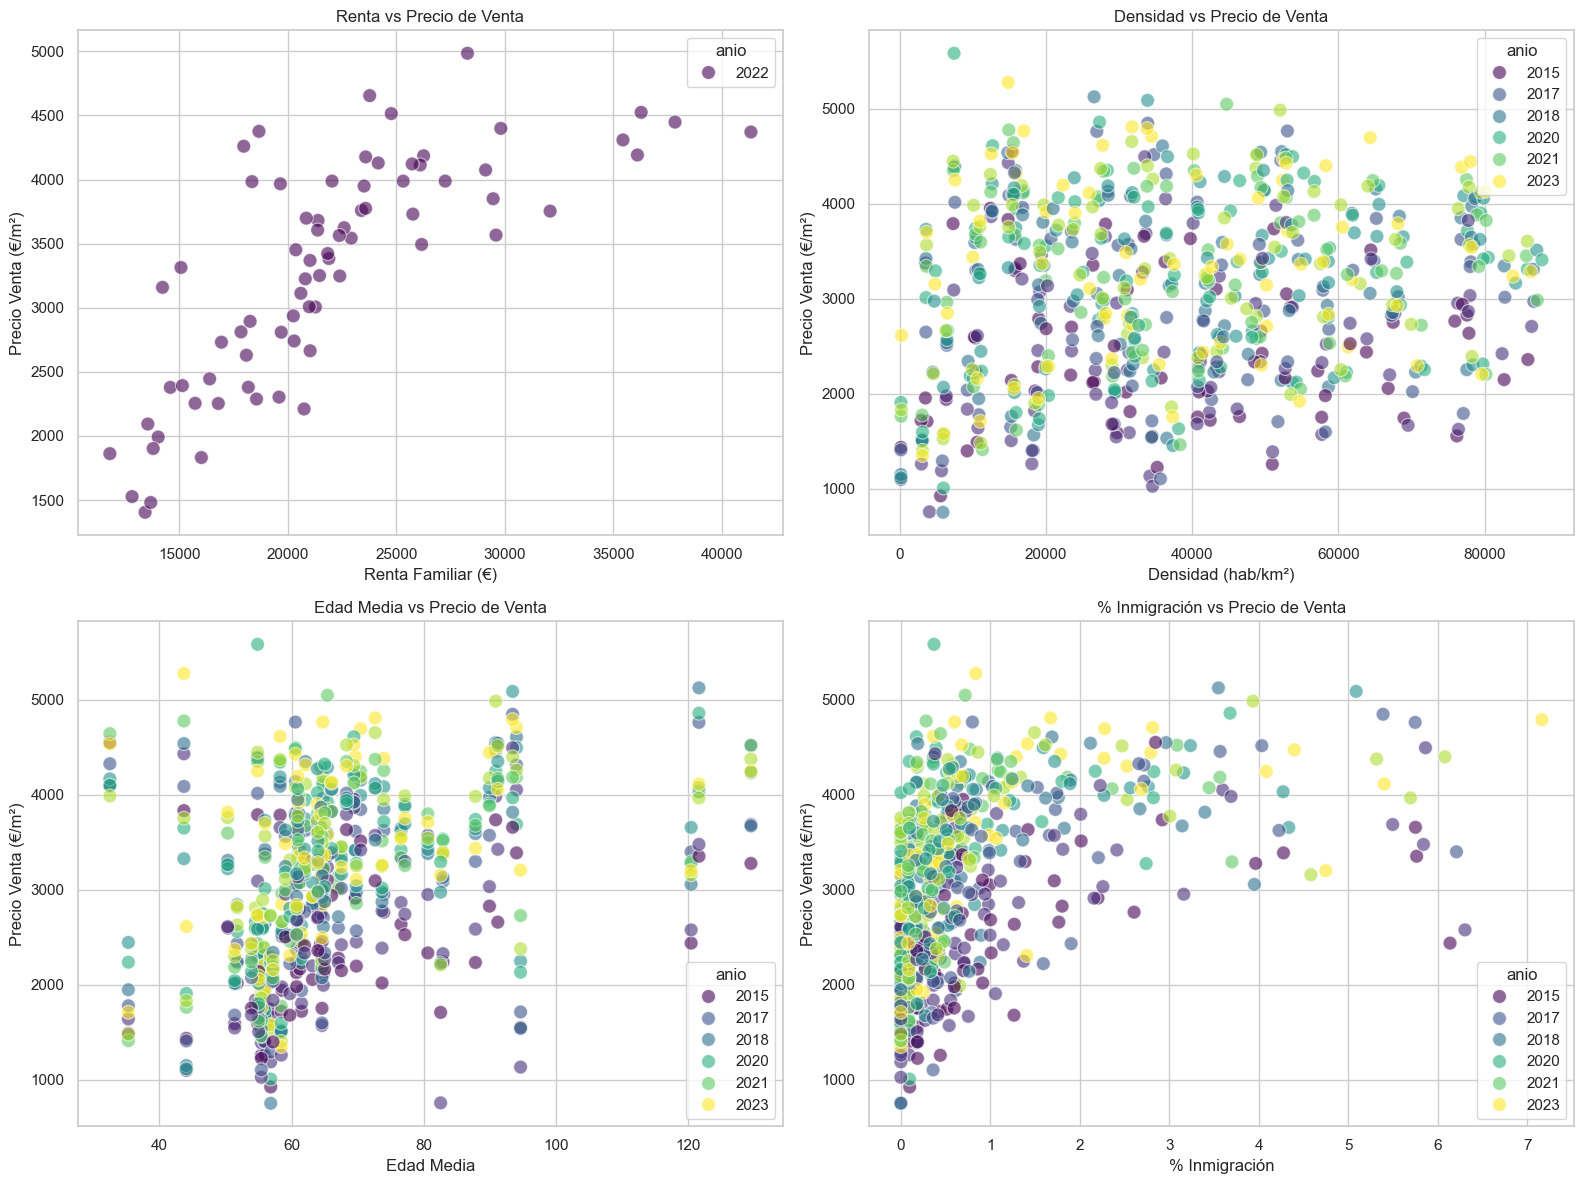

In [32]:
# Scatter Plots: Relaciones clave
if 'renta_familiar' in df_corr.columns and df_corr['renta_familiar'].notna().sum() > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Renta vs Precio
    df_plot = df_corr[df_corr['renta_familiar'].notna()]
    if not df_plot.empty:
        sns.scatterplot(data=df_plot, x='renta_familiar', y='precio_m2_venta', 
                       hue='anio', palette='viridis', ax=axes[0, 0], s=100, alpha=0.6)
        axes[0, 0].set_title('Renta vs Precio de Venta')
        axes[0, 0].set_xlabel('Renta Familiar (€)')
        axes[0, 0].set_ylabel('Precio Venta (€/m²)')
    
    # Densidad vs Precio
    sns.scatterplot(data=df_corr, x='densidad_hab_km2', y='precio_m2_venta', 
                   hue='anio', palette='viridis', ax=axes[0, 1], s=100, alpha=0.6)
    axes[0, 1].set_title('Densidad vs Precio de Venta')
    axes[0, 1].set_xlabel('Densidad (hab/km²)')
    axes[0, 1].set_ylabel('Precio Venta (€/m²)')
    
    # Edad Media vs Precio
    sns.scatterplot(data=df_corr, x='edad_media', y='precio_m2_venta', 
                   hue='anio', palette='viridis', ax=axes[1, 0], s=100, alpha=0.6)
    axes[1, 0].set_title('Edad Media vs Precio de Venta')
    axes[1, 0].set_xlabel('Edad Media')
    axes[1, 0].set_ylabel('Precio Venta (€/m²)')
    
    # Inmigración vs Precio
    df_plot_imm = df_corr[df_corr['porc_inmigracion'].notna()]
    if not df_plot_imm.empty:
        sns.scatterplot(data=df_plot_imm, x='porc_inmigracion', y='precio_m2_venta', 
                       hue='anio', palette='viridis', ax=axes[1, 1], s=100, alpha=0.6)
        axes[1, 1].set_title('% Inmigración vs Precio de Venta')
        axes[1, 1].set_xlabel('% Inmigración')
        axes[1, 1].set_ylabel('Precio Venta (€/m²)')
    
    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes datos de renta para scatter plots")

## 6. Visualización Geográfica

Visualización geográfica de precios, renta y demografía por barrio.

## 7. Detección de Valores Atípicos

Detección de valores atípicos en precios y demografía.


=== OUTLIERS EN PRECIOS DE VENTA ===
Límite inferior: -589€/m²
Límite superior: 6651€/m²
Número de outliers: 55 (1.0%)

Top 10 Outliers (más altos):
                               barrio_nombre     distrito_nombre  anio  precio_m2_venta
                    el Congrés i els Indians         Sant Andreu  2020         12452.82
                                   Pedralbes           Les Corts  2020         12154.22
                                      Sarrià Sarrià-Sant Gervasi  2025         10070.01
                             les Tres Torres Sarrià-Sant Gervasi  2021          8867.44
                                   Pedralbes           Les Corts  2024          8411.71
                      la Dreta de l'Eixample            Eixample  2025          8317.80
                       la Font de la Guatlla      Sants-Montjuïc  2021          8176.60
              la Nova Esquerra de l'Eixample            Eixample  2025          8137.90
                  Sant Gervasi - la Bonanova Sarrià-Sant Ge

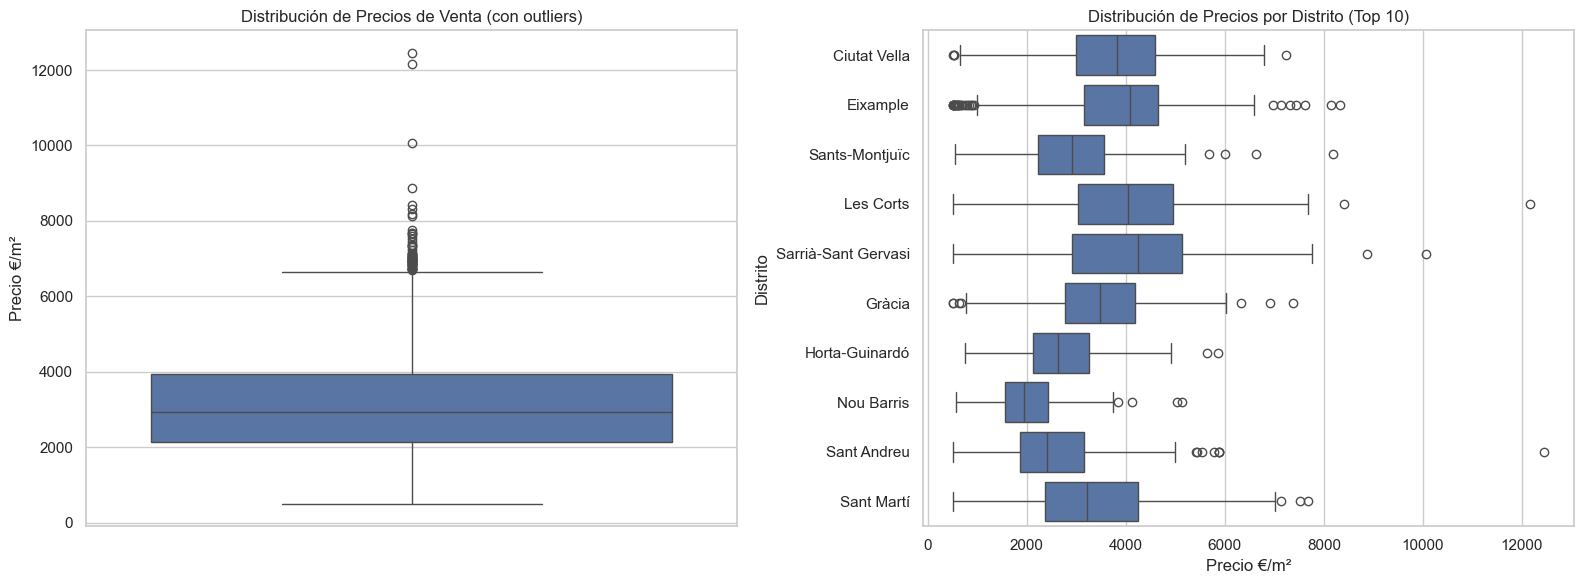

In [33]:
# Detección de outliers usando IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Outliers en precios
outliers_precio, lb_precio, ub_precio = detect_outliers_iqr(df_m2_venta, 'precio_m2_venta')
print(f"=== OUTLIERS EN PRECIOS DE VENTA ===")
print(f"Límite inferior: {lb_precio:.0f}€/m²")
print(f"Límite superior: {ub_precio:.0f}€/m²")
print(f"Número de outliers: {len(outliers_precio)} ({len(outliers_precio)/len(df_m2_venta)*100:.1f}%)")

if len(outliers_precio) > 0:
    outliers_precio_merged = outliers_precio.merge(
        df_barrios[['barrio_id', 'barrio_nombre', 'distrito_nombre']],
        on='barrio_id'
    )
    print("\nTop 10 Outliers (más altos):")
    print(outliers_precio_merged.nlargest(10, 'precio_m2_venta')[['barrio_nombre', 'distrito_nombre', 'anio', 'precio_m2_venta']].to_string(index=False))

# Box plots para visualizar outliers
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(data=df_m2_venta, y='precio_m2_venta', ax=axes[0])
axes[0].set_title('Distribución de Precios de Venta (con outliers)')
axes[0].set_ylabel('Precio €/m²')

# Box plot por distrito (top 10 distritos)
if not df_m2_venta.empty:
    df_m2_venta_dist = df_m2_venta.merge(
        df_barrios[['barrio_id', 'distrito_nombre']],
        on='barrio_id'
    )
    top_distritos = df_m2_venta_dist['distrito_nombre'].value_counts().head(10).index
    df_top_dist = df_m2_venta_dist[df_m2_venta_dist['distrito_nombre'].isin(top_distritos)]
    
    sns.boxplot(data=df_top_dist, x='precio_m2_venta', y='distrito_nombre', ax=axes[1])
    axes[1].set_title('Distribución de Precios por Distrito (Top 10)')
    axes[1].set_xlabel('Precio €/m²')
    axes[1].set_ylabel('Distrito')

plt.tight_layout()
plt.show()


## 8. Resumen y Conclusiones

### Hallazgos Clave

1. **Cobertura de Datos**:
   - ✅ Demografía: Completa (2015-2023, 73 barrios)
   - ✅ Precios de venta: Buena cobertura (2012-2025, 82.6% con datos)
   - ⚠️ Precios de alquiler: Limitada (17.4% con datos)
   - ⚠️ Renta: Solo 1 año disponible
   - ❌ Oferta Idealista: Sin datos

2. **Distribuciones**:
   - Los precios de venta muestran distribución normal con algunos valores atípicos
   - Población concentrada en ciertos distritos
   - La renta varía significativamente entre barrios

3. **Correlaciones**:
   - (Se mostrarán en la matriz de correlación)

### Próximos Pasos Recomendados

1. Completar extracción de oferta Idealista
2. Ampliar cobertura temporal de renta
3. Mejorar cobertura de datos de alquiler
4. Análisis más profundo de tendencias temporales


In [41]:
import json
import pandas as pd
import plotly.io as pio
import plotly.express as px

# 1. CONFIGURACIÓN
# 'notebook' es lo estándar. Si usas JupyterLab y no se ve, intenta 'iframe'
pio.renderers.default = "iframe"

# Verificación de seguridad basada en tu fila de ejemplo
required_cols = ['barrio_id', 'geometry_json', 'precio_m2_venta', 'barrio_nombre']
if not all(col in df_map.columns for col in required_cols):
    raise ValueError(f"Faltan columnas críticas en df_map. Se esperan: {required_cols}")

print(f"Generando mapas para {len(df_map)} barrios...")

# 2. CONSTRUCCIÓN DEL OBJETO GEOJSON
# Transformamos la columna 'geometry_json' (string) en un objeto FeatureCollection real
features = []
for _, row in df_map.iterrows():
    if pd.notna(row['geometry_json']):
        try:
            # Parseamos el string JSON a diccionario
            geom = json.loads(row['geometry_json']) if isinstance(row['geometry_json'], str) else row['geometry_json']
            
            features.append({
                "type": "Feature",
                "geometry": geom,
                "id": row['barrio_id'],  # CLAVE CRÍTICA: Enlace con el DataFrame
                "properties": {
                    "barrio": row['barrio_nombre']
                }
            })
        except (TypeError, json.JSONDecodeError) as e:
            print(f"Error en geometría barrio {row['barrio_id']}: {e}")
            continue

if not features:
    raise ValueError("No se pudieron procesar las geometrías. Revisa el formato de 'geometry_json'.")

geojson_obj = {"type": "FeatureCollection", "features": features}

# 3. CONFIGURACIÓN VISUAL COMPARTIDA
map_config = {
    "mapbox_style": "carto-positron",
    "zoom": 10.8,
    "center": {"lat": 41.39, "lon": 2.17}, # Centrado en Eixample
    "opacity": 0.7,
}
layout_config = {
    "margin": {"r":0,"t":40,"l":0,"b":0}
}

# ---------------------------------------------------------
# MAPA 1: PRECIO DE VENTA (El dato robusto)
# ---------------------------------------------------------
col_precio = 'precio_m2_venta'

if col_precio in df_map.columns:
    # Usamos cuantiles 5-95% para que Pedralbes no "aplane" la escala de color del resto
    min_val = df_map[col_precio].quantile(0.05)
    max_val = df_map[col_precio].quantile(0.95)

    fig1 = px.choropleth_mapbox(
        df_map,
        geojson=geojson_obj,
        locations='barrio_id',       # Columna del DF
        featureidkey="id",           # Clave del GeoJSON ('id' que asignamos arriba)
        color=col_precio,
        color_continuous_scale="Viridis",
        range_color=[min_val, max_val],
        title=f"Precio Medio Venta (€/m²) - {df_map['anio'].max()}",
        hover_name='barrio_nombre',
        hover_data={col_precio: ':,.0f', 'barrio_id': False},
        labels={col_precio: 'Precio (€/m²)'},
        **map_config
    )
    fig1.update_layout(**layout_config)
    from IPython.display import HTML
    display(HTML(fig1.to_html(include_plotlyjs="cdn")))

# ---------------------------------------------------------
# MAPA 2: RENTA FAMILIAR (Contexto socioeconómico)
# ---------------------------------------------------------
col_renta = 'renta_familiar'

if col_renta in df_map.columns and df_map[col_renta].notna().sum() > 0:
    fig2 = px.choropleth_mapbox(
        df_map,
        geojson=geojson_obj,
        locations='barrio_id',
        featureidkey="id",
        color=col_renta,
        color_continuous_scale="RdYlGn", # Rojo=Baja, Verde=Alta
        title=f"Renta Familiar Disponible (€)",
        hover_name='barrio_nombre',
        hover_data={col_renta: ':,.0f', 'barrio_id': False},
        labels={col_renta: 'Renta (€)'},
        **map_config
    )
    fig2.update_layout(**layout_config)
    display(HTML(fig2.to_html(include_plotlyjs="cdn")))

# ---------------------------------------------------------
# MAPA 3: ESFUERZO DE COMPRA (Proxy de Affordability)
# ---------------------------------------------------------
# Calculamos al vuelo: Cuántos años de renta íntegra cuesta un piso de 80m2
if col_renta in df_map.columns and col_precio in df_map.columns:
    # Crear métrica calculada
    df_map['esfuerzo_compra'] = (df_map[col_precio] * 80) / df_map[col_renta]
    
    # Filtramos infinitos o nulos por si falta renta
    df_esfuerzo = df_map.dropna(subset=['esfuerzo_compra'])

    if not df_esfuerzo.empty:
        fig3 = px.choropleth_mapbox(
            df_esfuerzo,
            geojson=geojson_obj,
            locations='barrio_id',
            featureidkey="id",
            color='esfuerzo_compra',
            color_continuous_scale="RdYlGn_r", # Invertido: Rojo=Mucho esfuerzo, Verde=Poco
            title=f"Esfuerzo: Años de renta para comprar 80m²",
            hover_name='barrio_nombre',
            hover_data={'esfuerzo_compra': ':.1f', 'barrio_id': False},
            labels={'esfuerzo_compra': 'Años de Renta'},
            **map_config
        )
        fig3.update_layout(**layout_config)
        fig3.show()

Generando mapas para 73 barrios...


/var/folders/8t/1rzjlj6n3rj3v08skl2pwjbm0000gn/T/ipykernel_77700/245044895.py:64: DeprecationWarning:

*choropleth_mapbox* is deprecated! Use *choropleth_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

